In [1]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 24.2 MB 9.3 MB/s eta 0:00:011
     |████████████████████████████████| 117 kB 11.3 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-4.0.1-py3-none-any.whl size=108249 sha256=ff11e8c5bcc4cbc665fb1a44353372463f02d6be30cab03b25578b042f41d3af
  Stored in directory: /Users/dodo4.0/Library/Caches/pip/wheels/34/3d/14/f19c01a19c9201cdb6a76b049904d5226912569be919ad1eae
Successfully built smart-open
Defaulting to user installation because normal site-packages is not writeable
  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 9.9 MB 8.5 MB/s eta 0:00:01     |██████████████████▊             | 5.8 MB 1.4 MB/s eta 0:00:03


In [3]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dodo4.0/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [11]:
dataset_filename = os.listdir("./input")[0]
print(dataset_filename)
dataset_path = os.path.join(".","input",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

training.1600000.processed.noemoticon.csv
Open file: ./input/training.1600000.processed.noemoticon.csv


In [12]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [13]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [14]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [15]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 436 ms, sys: 9.11 ms, total: 446 ms
Wall time: 458 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

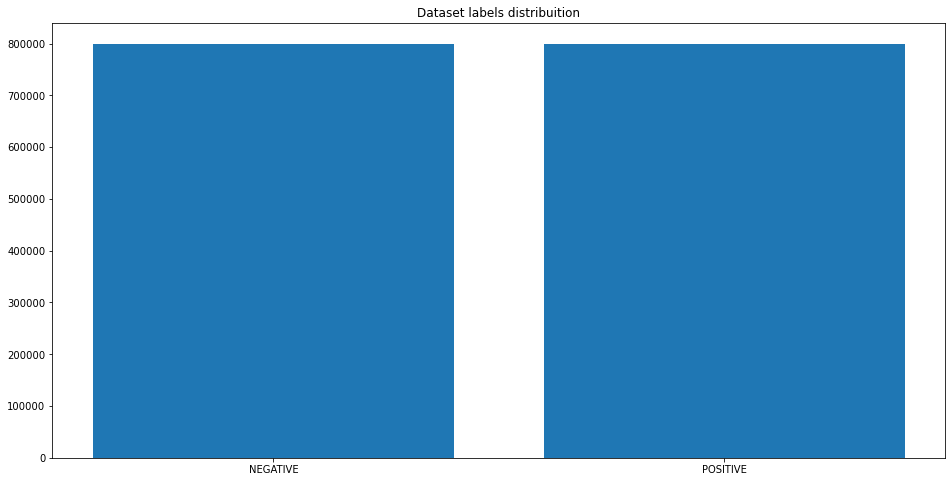

In [16]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [17]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [18]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [19]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 45.1 s, sys: 185 ms, total: 45.3 s
Wall time: 45.7 s


In [20]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [21]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.48 s, sys: 311 ms, total: 2.79 s
Wall time: 2.96 s


In [22]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [23]:
w2v_model.build_vocab(documents)

2020-12-04 15:02:13,557 : INFO : collecting all words and their counts
2020-12-04 15:02:13,559 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-04 15:02:13,579 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-12-04 15:02:13,597 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-12-04 15:02:13,635 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-12-04 15:02:13,667 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-12-04 15:02:13,703 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-12-04 15:02:13,729 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-12-04 15:02:13,759 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-12-04 15:02:13,789 : INFO : PROGRESS: at s

2020-12-04 15:02:15,979 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-12-04 15:02:16,015 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-12-04 15:02:16,047 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-12-04 15:02:16,077 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-12-04 15:02:16,107 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-12-04 15:02:16,130 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-12-04 15:02:16,157 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-12-04 15:02:16,186 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-12-04 15:02:16,215 : INFO : PROGRESS: at sentence #800000, processed 577088

In [24]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [25]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-12-04 15:02:35,795 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-12-04 15:02:36,834 : INFO : EPOCH 1 - PROGRESS: at 8.90% examples, 721894 words/s, in_qsize 12, out_qsize 2
2020-12-04 15:02:37,856 : INFO : EPOCH 1 - PROGRESS: at 19.62% examples, 792707 words/s, in_qsize 15, out_qsize 0
2020-12-04 15:02:38,924 : INFO : EPOCH 1 - PROGRESS: at 29.38% examples, 778428 words/s, in_qsize 15, out_qsize 0
2020-12-04 15:02:39,934 : INFO : EPOCH 1 - PROGRESS: at 37.70% examples, 754081 words/s, in_qsize 14, out_qsize 1
2020-12-04 15:02:40,941 : INFO : EPOCH 1 - PROGRESS: at 45.48% examples, 731031 words/s, in_qsize 16, out_qsize 0
2020-12-04 15:02:41,958 : INFO : EPOCH 1 - PROGRESS: at 52.62% examples, 705839 words/s, in_qsize 14, out_qsize 1
2020-12-04 15:02:42,965 : INFO : EPOCH 1 - PROGRESS: at 59.76% examples, 688633 words/s, in_qsize 15, out_qsize 1
2020-12-04 15:02:43,968 : INFO : EPOCH 1 - PROGRESS: 

2020-12-04 15:03:22,113 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-04 15:03:22,145 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-04 15:03:22,149 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-04 15:03:22,149 : INFO : EPOCH - 4 : training on 9227204 raw words (8222860 effective words) took 9.4s, 877212 effective words/s
2020-12-04 15:03:23,183 : INFO : EPOCH 5 - PROGRESS: at 10.75% examples, 874953 words/s, in_qsize 15, out_qsize 0
2020-12-04 15:03:24,188 : INFO : EPOCH 5 - PROGRESS: at 21.68% examples, 884956 words/s, in_qsize 16, out_qsize 0
2020-12-04 15:03:25,204 : INFO : EPOCH 5 - PROGRESS: at 32.73% examples, 888486 words/s, in_qsize 13, out_qsize 2
2020-12-04 15:03:26,206 : INFO : EPOCH 5 - PROGRESS: at 43.64% examples, 890805 words/s, in_qsize 15, out_qsize 0
2020-12-04 15:03:27,221 : INFO : EPOCH 5 - PROGRESS: at 54.46% examples, 888292 words/s, in_qsize 15, out_qsize 0
2020-12-04 15:03:28,

2020-12-04 15:04:03,020 : INFO : EPOCH 9 - PROGRESS: at 31.65% examples, 853200 words/s, in_qsize 15, out_qsize 4
2020-12-04 15:04:04,036 : INFO : EPOCH 9 - PROGRESS: at 40.73% examples, 823916 words/s, in_qsize 16, out_qsize 0
2020-12-04 15:04:05,078 : INFO : EPOCH 9 - PROGRESS: at 50.24% examples, 809389 words/s, in_qsize 16, out_qsize 4
2020-12-04 15:04:06,085 : INFO : EPOCH 9 - PROGRESS: at 61.28% examples, 824789 words/s, in_qsize 15, out_qsize 0
2020-12-04 15:04:07,091 : INFO : EPOCH 9 - PROGRESS: at 72.42% examples, 837253 words/s, in_qsize 16, out_qsize 0
2020-12-04 15:04:08,112 : INFO : EPOCH 9 - PROGRESS: at 83.07% examples, 839459 words/s, in_qsize 15, out_qsize 0
2020-12-04 15:04:09,165 : INFO : EPOCH 9 - PROGRESS: at 94.15% examples, 841998 words/s, in_qsize 16, out_qsize 1
2020-12-04 15:04:09,638 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-04 15:04:09,641 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-04 15:04:09,

2020-12-04 15:04:47,780 : INFO : EPOCH 13 - PROGRESS: at 95.44% examples, 862742 words/s, in_qsize 16, out_qsize 0
2020-12-04 15:04:48,115 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-04 15:04:48,129 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-04 15:04:48,148 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-04 15:04:48,156 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-04 15:04:48,161 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-04 15:04:48,161 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-04 15:04:48,173 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-04 15:04:48,183 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-04 15:04:48,183 : INFO : EPOCH - 13 : training on 9227204 raw words (8222238 effective words) took 9.5s, 865583 effective words/s
2020-12-04 15:04:49

2020-12-04 15:05:28,146 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-04 15:05:28,149 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-04 15:05:28,153 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-04 15:05:28,161 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-04 15:05:28,164 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-04 15:05:28,164 : INFO : EPOCH - 17 : training on 9227204 raw words (8223109 effective words) took 11.4s, 722078 effective words/s
2020-12-04 15:05:29,223 : INFO : EPOCH 18 - PROGRESS: at 5.21% examples, 408622 words/s, in_qsize 15, out_qsize 0
2020-12-04 15:05:30,242 : INFO : EPOCH 18 - PROGRESS: at 10.42% examples, 414460 words/s, in_qsize 16, out_qsize 0
2020-12-04 15:05:31,268 : INFO : EPOCH 18 - PROGRESS: at 18.65% examples, 495712 words/s, in_qsize 16, out_qsize 0
2020-12-04 15:05:32,275 : INFO : EPOCH 18 - PROGRESS: at 26.23

2020-12-04 15:06:15,086 : INFO : EPOCH 21 - PROGRESS: at 48.19% examples, 785327 words/s, in_qsize 16, out_qsize 0
2020-12-04 15:06:16,093 : INFO : EPOCH 21 - PROGRESS: at 56.84% examples, 772509 words/s, in_qsize 16, out_qsize 0
2020-12-04 15:06:17,134 : INFO : EPOCH 21 - PROGRESS: at 66.04% examples, 765895 words/s, in_qsize 15, out_qsize 0
2020-12-04 15:06:18,163 : INFO : EPOCH 21 - PROGRESS: at 76.44% examples, 774089 words/s, in_qsize 16, out_qsize 1
2020-12-04 15:06:19,171 : INFO : EPOCH 21 - PROGRESS: at 86.21% examples, 776354 words/s, in_qsize 16, out_qsize 0
2020-12-04 15:06:20,192 : INFO : EPOCH 21 - PROGRESS: at 95.99% examples, 777208 words/s, in_qsize 14, out_qsize 2
2020-12-04 15:06:20,492 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-04 15:06:20,493 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-04 15:06:20,502 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-04 15:06:20,509 : INFO : work

2020-12-04 15:06:58,830 : INFO : EPOCH 25 - PROGRESS: at 20.48% examples, 835554 words/s, in_qsize 14, out_qsize 1
2020-12-04 15:06:59,851 : INFO : EPOCH 25 - PROGRESS: at 31.21% examples, 845169 words/s, in_qsize 15, out_qsize 1
2020-12-04 15:07:00,868 : INFO : EPOCH 25 - PROGRESS: at 41.80% examples, 848511 words/s, in_qsize 16, out_qsize 0
2020-12-04 15:07:01,901 : INFO : EPOCH 25 - PROGRESS: at 52.51% examples, 849499 words/s, in_qsize 15, out_qsize 0
2020-12-04 15:07:02,909 : INFO : EPOCH 25 - PROGRESS: at 63.54% examples, 858091 words/s, in_qsize 16, out_qsize 0
2020-12-04 15:07:03,926 : INFO : EPOCH 25 - PROGRESS: at 74.37% examples, 860602 words/s, in_qsize 14, out_qsize 2
2020-12-04 15:07:04,934 : INFO : EPOCH 25 - PROGRESS: at 84.15% examples, 852586 words/s, in_qsize 15, out_qsize 0
2020-12-04 15:07:05,942 : INFO : EPOCH 25 - PROGRESS: at 94.91% examples, 854944 words/s, in_qsize 15, out_qsize 0
2020-12-04 15:07:06,360 : INFO : worker thread finished; awaiting finish of 7 mo

2020-12-04 15:07:43,908 : INFO : EPOCH 29 - PROGRESS: at 61.61% examples, 841371 words/s, in_qsize 15, out_qsize 0
2020-12-04 15:07:44,909 : INFO : EPOCH 29 - PROGRESS: at 72.43% examples, 848181 words/s, in_qsize 15, out_qsize 0
2020-12-04 15:07:45,918 : INFO : EPOCH 29 - PROGRESS: at 83.07% examples, 850328 words/s, in_qsize 16, out_qsize 0
2020-12-04 15:07:46,920 : INFO : EPOCH 29 - PROGRESS: at 93.81% examples, 853512 words/s, in_qsize 16, out_qsize 1
2020-12-04 15:07:47,444 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-04 15:07:47,446 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-04 15:07:47,447 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-04 15:07:47,464 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-04 15:07:47,467 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-04 15:07:47,468 : INFO : worker thread finished; awaiting finish of 2 more th

CPU times: user 17min 31s, sys: 7.28 s, total: 17min 38s
Wall time: 5min 40s


(263127379, 295270528)

In [26]:
w2v_model.most_similar("love")

/Users/dodo4.0/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-12-04 15:10:05,844 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5688667297363281),
 ('loves', 0.5516188144683838),
 ('loved', 0.550737738609314),
 ('adore', 0.5176335573196411),
 ('amazing', 0.5148882269859314),
 ('looove', 0.4862058162689209),
 ('awesome', 0.4775022268295288),
 ('loveee', 0.46532952785491943),
 ('lovee', 0.4433733820915222),
 ('loooove', 0.4388321042060852)]

In [27]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 15.8 s, sys: 415 ms, total: 16.3 s
Wall time: 16.6 s


In [28]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)


CPU times: user 23.2 s, sys: 3.28 s, total: 26.5 s
Wall time: 29.1 s


In [29]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [30]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [31]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [32]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [33]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [34]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [35]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [36]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [37]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [38]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.7512WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-12-04 18:06:24,462 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 10355s 9s/step - loss: 0.5029 - accuracy: 0.7512 - val_loss: 0.4661 - val_accuracy: 0.7790
Epoch 2/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4779 - accuracy: 0.7684WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-12-04 20:50:28,603 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 9831s 9s/step - loss: 0.4779 - accuracy: 0.7684 - val_loss: 0.4578 - val_accuracy: 0.7844
Epoch 3/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4714 - accuracy: 0.7724WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-12-04 23:33:09,674 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 9751s 9s/step - loss: 0.4714 - accuracy: 0.7724 - val_loss: 0.4523 - val_accuracy: 0.7865
Epoch 4/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4676 - accuracy: 0.7745WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-12-05 02:28:51,299 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 10530s 9s/step - loss: 0.4676 - accuracy: 0.7745 - val_loss: 0.4525 - val_accuracy: 0.7874
Epoch 5/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4654 - accuracy: 0.7762WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-12-05 04:47:40,198 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 8320s 7s/step - loss: 0.4654 - accuracy: 0.7762 - val_loss: 0.4506 - val_accuracy: 0.7889
Epoch 6/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4634 - accuracy: 0.7774WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-12-05 07:08:03,346 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 8415s 7s/step - loss: 0.4634 - accuracy: 0.7774 - val_loss: 0.4478 - val_accuracy: 0.7895
Epoch 7/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4622 - accuracy: 0.7779WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-12-05 09:27:07,874 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 8336s 7s/step - loss: 0.4622 - accuracy: 0.7779 - val_loss: 0.4468 - val_accuracy: 0.7901
Epoch 8/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4609 - accuracy: 0.7787WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-12-05 11:51:28,396 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 8652s 8s/step - loss: 0.4609 - accuracy: 0.7787 - val_loss: 0.4452 - val_accuracy: 0.7905
CPU times: user 1d 18h 20s, sys: 18h 8min 45s, total: 2d 12h 9min 5s
Wall time: 20h 37min 52s


In [39]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 558s 2s/step - loss: 0.4441 - accuracy: 0.7913

ACCURACY: 0.791265606880188
LOSS: 0.4441477954387665
CPU times: user 19min 26s, sys: 5min 14s, total: 24min 41s
Wall time: 9min 20s


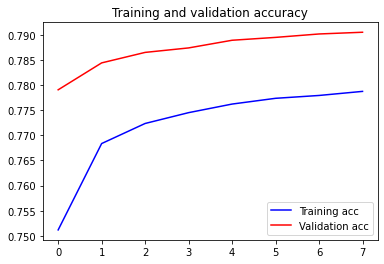

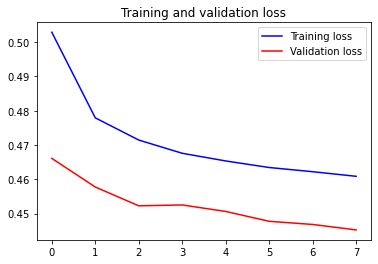

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [43]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [44]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [45]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9617032408714294,
 'elapsed_time': 0.42303895950317383}

In [46]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.010683596134185791,
 'elapsed_time': 0.1080169677734375}

In [47]:
predict("i don't know what i'm doing")

{'label': 'NEGATIVE',
 'score': 0.3052173852920532,
 'elapsed_time': 0.08829617500305176}

In [48]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 470s 12s/step
CPU times: user 18min 7s, sys: 6min 25s, total: 24min 32s
Wall time: 8min 12s


In [49]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

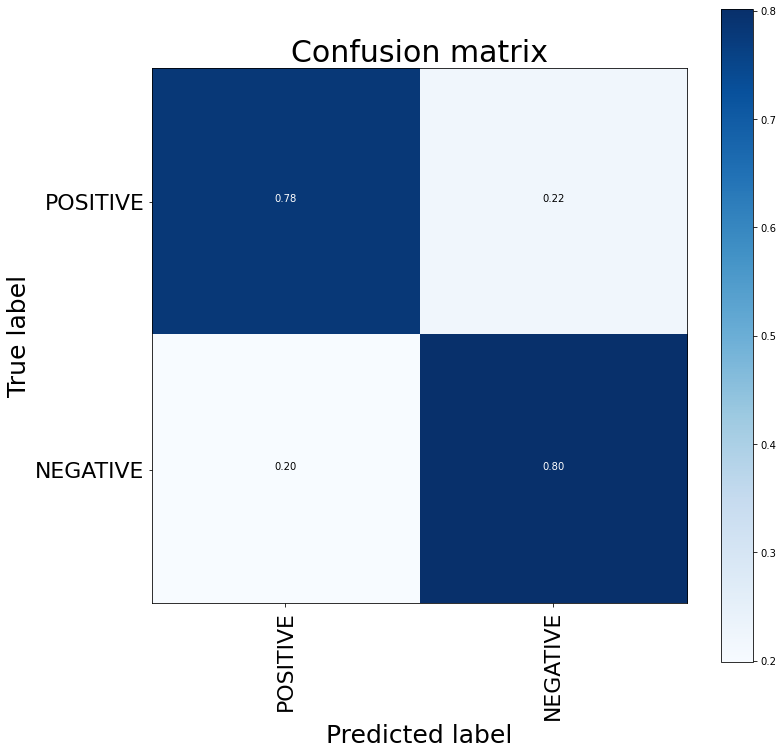

CPU times: user 1.27 s, sys: 154 ms, total: 1.42 s
Wall time: 1.82 s


In [50]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [51]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.78      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [52]:
accuracy_score(y_test_1d, y_pred_1d)

0.791265625

In [53]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-12-05 12:18:03,789 : INFO : saving Word2Vec object under model.w2v, separately None
2020-12-05 12:18:03,805 : INFO : not storing attribute vectors_norm
2020-12-05 12:18:03,807 : INFO : not storing attribute cum_table
2020-12-05 12:18:05,696 : INFO : saved model.w2v


In [54]:
predict('Who\'s here in December and literally cannot wait for Christmas 🎄🤣')

{'label': 'POSITIVE',
 'score': 0.9477497339248657,
 'elapsed_time': 0.17639493942260742}

In [55]:
predict('I\'m telling my kids Mariah is Santa Clause')

{'label': 'NEUTRAL',
 'score': 0.6976704597473145,
 'elapsed_time': 0.1211550235748291}

In [56]:
predict('When Mariah Carey dies she will leave a void in the world. I hope there is a long way to go for that :´´ )')

{'label': 'NEGATIVE',
 'score': 0.28031542897224426,
 'elapsed_time': 0.1130361557006836}

In [57]:
predict('Listening to this makes me forget that there\'s a pandemic.')

{'label': 'POSITIVE',
 'score': 0.9284753799438477,
 'elapsed_time': 0.10547518730163574}

In [59]:
predict('"Who\'s here in October and literally cannot wait for Christmas 🎄🤣👇"')

{'label': 'POSITIVE',
 'score': 0.931087851524353,
 'elapsed_time': 0.10805892944335938}

In [60]:
predict('This year has been crazy, and I can\'t believe it\'s December already. Merry Christmas everyone, remember that you are strong and amazing!!!')

{'label': 'POSITIVE',
 'score': 0.9425585865974426,
 'elapsed_time': 0.09743213653564453}

In [61]:
predict('Let\'s be honest, we all searched for the song.')

{'label': 'POSITIVE',
 'score': 0.7442891597747803,
 'elapsed_time': 0.08665227890014648}

In [62]:
predict('Bro I’m just depressed that it’s not Christmas right now')

{'label': 'NEGATIVE',
 'score': 0.0262967050075531,
 'elapsed_time': 0.10167694091796875}

In [63]:
predict('I\'ve been listening to this song every Christmas season.')

{'label': 'POSITIVE',
 'score': 0.8805539608001709,
 'elapsed_time': 0.08898305892944336}

In [64]:
predict('why is nobody talking about how cute is this little girl')

{'label': 'POSITIVE',
 'score': 0.8425670862197876,
 'elapsed_time': 0.09133005142211914}